In [1]:
import pandas as pd 
import numpy as np

import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau 
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.regularizers import l2

import sys
sys.path.append('../')
from Utils import utils_nn as utlnn

In [2]:
x_test = pd.read_excel("../Train_Test/Dataset_Separado/x_test_new.xlsx")
x_train = pd.read_excel("../Train_Test/Dataset_Separado/x_train_new.xlsx")
y_test = pd.read_excel("../Train_Test/Dataset_Separado/y_test_new.xlsx")
y_train = pd.read_excel("../Train_Test/Dataset_Separado/y_train_new.xlsx")

In [3]:
## De mi y_train y y_test solo quiero las coordenadas Z
R0 = 6.371E6
out_z_coord = [f'z_{i}' for i in range(1,101)]
y_train_z = y_train[out_z_coord]/R0
y_test_z = y_test[out_z_coord]/R0
# 'y_test_z son las columnas filtradas de las 3 coordenadas'

In [4]:
print("Forma de x_train:", x_train.shape)

for i, col_name in enumerate(x_train.columns):
    col = x_train[col_name]
    print(f"Columna {i} ({col_name}): min={col.min():.4f}, max={col.max():.4f}, mean={col.mean():.4f}, std={col.std():.4f}")


Forma de x_train: (4104, 9)
Columna 0 (latitude_pos_tx): min=-42.2800, max=-42.2800, mean=-42.2800, std=0.0000
Columna 1 (longitude_pos_tx): min=-63.4000, max=-63.4000, mean=-63.4000, std=0.0000
Columna 2 (elevation_pos_tx): min=0.0000, max=0.0000, mean=0.0000, std=0.0000
Columna 3 (fc [Mhz]): min=3.0000, max=30.0000, mean=13.7032, std=6.9191
Columna 4 (elevation): min=0.0000, max=40.0000, mean=13.6659, std=11.8820
Columna 5 (azimuth): min=87.0000, max=98.0000, mean=92.8209, std=4.5824
Columna 6 (year): min=2010.0000, max=2010.0000, mean=2010.0000, std=0.0000
Columna 7 (mmdd): min=101.0000, max=1231.0000, mean=985.1394, std=348.8719
Columna 8 (hour): min=0.0000, max=20.0000, mean=11.1647, std=4.5880


De toda la Información anterior observo que las columnas como.
latitude_pos_tx: -42.28 (valor único y constante)
longitude_pos_tx: -63.40 (valor único y constante)
elevation_pos_tx: 0.0 (valor único y constante)
year: 2010 (valor único y constante)

Estas 4 columnas tienen desviacion estándar 0, es decir, no aportan nada al aprendizaje del modelo.\
**Nota**: Los modelos de ML aprenden de las variaciones, y esas columnas no tienen ninguna.\
Procedemos a quitarlos del x_train/test

In [5]:
x_train = x_train.drop(columns = ['latitude_pos_tx', 'longitude_pos_tx', 'elevation_pos_tx', 'year'])
x_test = x_test.drop(columns =['latitude_pos_tx', 'longitude_pos_tx', 'elevation_pos_tx', 'year'])

In [6]:
#Normalizamos la salida
from sklearn.preprocessing import MinMaxScaler

scaler_z = MinMaxScaler()
y_train_z_scaled = scaler_z.fit_transform(y_train_z)
y_test_z_scaled = scaler_z.transform(y_test_z)

In [7]:
early_stopping = EarlyStopping(
  monitor = 'val_loss',	#monitoriamos la pérdida en validación
  patience = 30, # Si no mejora en 10->20 epochs, detenemos el entrenamiento.
  restore_best_weights = True # Restaura los mejores pesos encontrados.
)
reduce_lr = ReduceLROnPlateau(
  monitor = 'val_loss',
  patience = 20,
  factor = 0.5
)

In [8]:
from tensorflow.keras.optimizers import RMSprop, Adam, AdamW

act_name = "relu"
l2_reg = 0.0007
epoch = 700
b_s= 64
optimizer_name = Adam(learning_rate = 1e-3)

inputs = Input(shape=(5,))
encoded = Dense(32, activation= act_name, kernel_regularizer= l2(l2_reg))(inputs)
encoded = Dense(64, activation= act_name, kernel_regularizer= l2(l2_reg))(encoded)
encoded = Dense(128, activation=act_name, kernel_regularizer=l2(l2_reg))(encoded)
encoded = Dense(256, activation=act_name, kernel_regularizer=l2(l2_reg))(encoded)
decoded = Dense(100, activation= 'linear', kernel_regularizer= l2(l2_reg), name ='z_output')(encoded)

autoencoder_z = Model(inputs, decoded)
autoencoder_z.compile(optimizer = optimizer_name, loss= 'mae') 
autoencoder_z.summary()

history = autoencoder_z.fit(x_train,y_train_z_scaled,
														epochs = epoch,
														batch_size = b_s,
														validation_split = 0.1,
                            callbacks = [reduce_lr, early_stopping]
                            )


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 5)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ z_output (Dense)                │ (None, 100)            │        25,700 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 69,348 (270.89 KB)

 Trainable params: 69,348 (270.89 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/700
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 6.1708 - val_loss: 0.4810 - learning_rate: 0.0010
Epoch 2/700
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4397 - val_loss: 0.3700 - learning_rate: 0.0010
Epoch 3/700
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3619 - val_loss: 0.3533 - learning_rate: 0.0010
Epoch 4/700
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3273 - val_loss: 0.2922 - learning_rate: 0.0010
Epoch 5/700
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2981 - val_loss: 0.2727 - learning_rate: 0.0010
Epoch 6/700
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2854 - val_loss: 0.2955 - learning_rate: 0.0010
Epoch 7/700
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2791 - val_loss: 0.2764 - learning_rate: 0.0010
Epoch 8/700
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2619 - val_loss: 0.2457 - learning_rate: 0.0010
Epoch 9/700
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2559 - val_loss: 0.2515 - learning_rate: 0.0010
Epoch 10/700
58/58 

Nota: si los batch_size son muy grandes es decir la actualización de los pesos por lotes. no finaliza la cantidad de epochs ya sea xq el learning rate es muy bajo o por que el early stopping detiene el entrenamiento por falta de mejora 


In [9]:
loss = autoencoder_z.evaluate(x_test,y_test_z_scaled)
print(f'Pérdida en datos de Test: {loss}')

# mae_in_m = loss[1]*R0
# print(f'mae:{mae_in_m}[m]')

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0346
Pérdida en datos de Test: 0.034813448786735535


In [33]:
idx = 80
 # Elegir una muestra para comparar (observar luego la muestra 30)
# Predicción de una muestra 
y_pred_scaled = autoencoder_z.predict(np.expand_dims(x_test.iloc[idx], axis=0))
###############################################
y_true = y_test_z.iloc[idx] # Se obtine Algo de tipo Serie
y_true=y_true.to_numpy() # Transform a Numpy array

#Desnormalizamos
y_pred = scaler_z.inverse_transform(y_pred_scaled)
y_pred = y_pred.flatten() # [[...,...,...,....,]]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


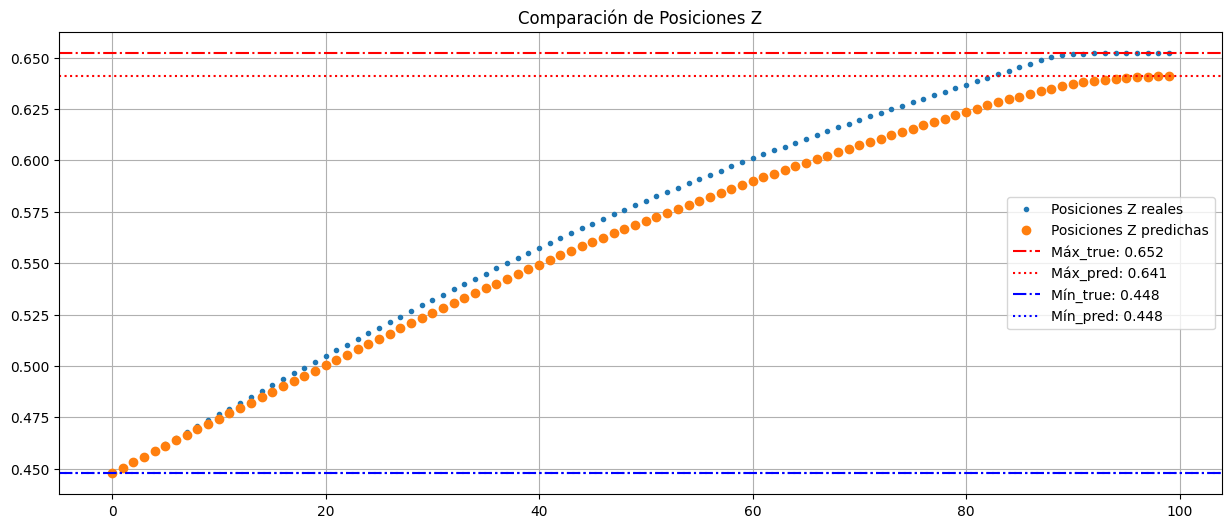

In [34]:
##Graficamos 
# Buscamos los máximos y mínimos 
y_true_max = np.max(y_true)
y_true_min = np.min(y_true)

y_pred_max = np.max(y_pred)
y_pred_min = np.min(y_pred)

# Pos z
plt.figure(figsize=(15, 6))
plt.plot(y_true, label='Posiciones Z reales', linestyle='None', marker='.')
plt.plot(y_pred, label='Posiciones Z predichas', linestyle = 'None',marker='o')
# Dibujamos los max y min
plt.axhline(y = y_true_max, color = 'red', linestyle = '-.', label=f'Máx_true: {y_true_max:.3f}')
plt.axhline(y = y_pred_max, color = 'red', linestyle = ':', label= f'Máx_pred: {y_pred_max:.3f}')
plt.axhline(y = y_true_min, color = 'blue', linestyle ='-.', label=f'Mín_true: {y_true_min:.3f}')
plt.axhline(y = y_pred_min, color = 'blue', linestyle = ':',label= f'Mín_pred:{y_pred_min: .3f}')

# plt.ylim(-35,-50) ##(-60,-30)
plt.title('Comparación de Posiciones Z')
plt.legend()
plt.grid(True)
plt.show()

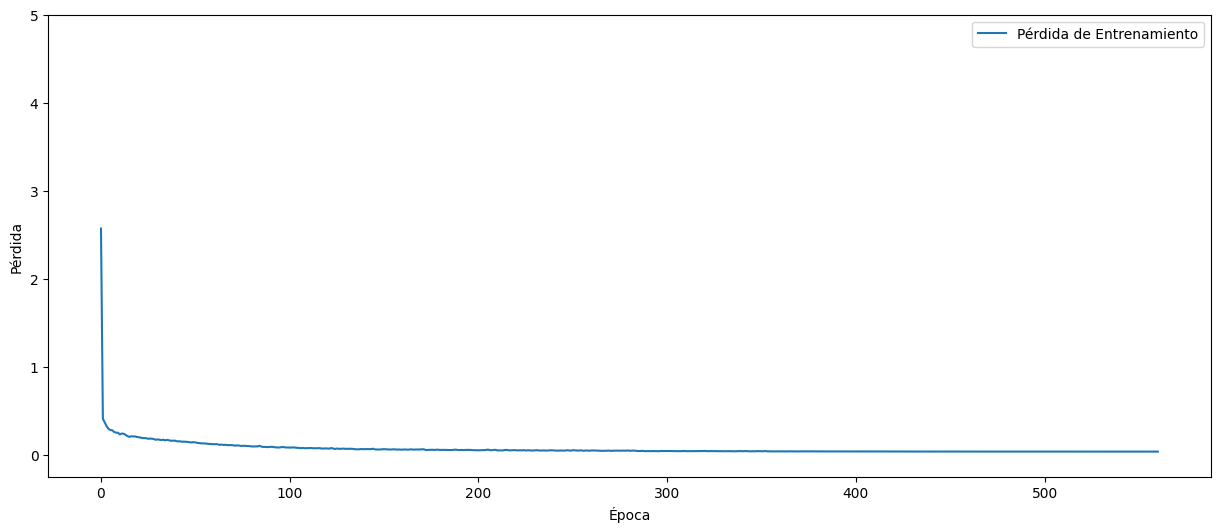

In [18]:
# Función de Pérdida durante el entrenamiento
plt.figure(figsize=(15,6))
plt.plot(history.history['loss'], label = 'Pérdida de Entrenamiento')
#plt.plot(history.history['val_loss'], label = 'Pérdida de validación')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.ylim(-0.25,5)
plt.legend()
plt.show()

In [ ]:
# #Guardado de Modelo.
# autoencoder_z.save("../modelos_entrenamiento/mod_z_R0/modelo2/modelo2.keras")

# #Guardado de Scaler
# import pickle
# with open('../modelos_entrenamiento/mod_z_R0/modelo2/scaler_z2.pkl','wb') as f:
#   pickle.dump(scaler_z,f)